# Extract Audio Features

In [1]:
import os
import numpy as np
import librosa
from tqdm import tqdm
import pickle

# Set your CREMA-D audio directory
CREMA_DIR = 'AudioWAV/'  # Update this to your path

# Map short labels to full emotion names
emotion_map = {
    'ANG': 'angry',
    'DIS': 'disgust',
    'FEA': 'fearful',
    'HAP': 'happy',
    'NEU': 'neutral',
    'SAD': 'sad'
}

# Feature extraction function (same as before)
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)

    if y.size < sr:
        y = np.pad(y, (0, sr - y.size))

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    rmse = librosa.feature.rms(y=y)
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)

    pitch = pitches[pitches > 0]
    pitch_mean = np.mean(pitch) if pitch.any() else 0

    return np.hstack([
        np.mean(mfcc.T, axis=0),
        np.mean(chroma.T, axis=0),
        np.mean(mel.T, axis=0),
        np.mean(contrast.T, axis=0),
        np.mean(zcr),
        np.mean(rmse),
        pitch_mean
    ])

# Loop through and extract features
X = []
y = []

for file in tqdm(os.listdir(CREMA_DIR)):
    if file.endswith('.wav'):
        parts = file.split('_')
        if len(parts) >= 4:
            emotion_code = parts[2]
            emotion_label = emotion_map.get(emotion_code)
            if emotion_label:
                full_path = os.path.join(CREMA_DIR, file)
                try:
                    features = extract_features(full_path)
                    X.append(features)
                    y.append(emotion_label)
                except Exception as e:
                    print(f"Error processing {file}: {e}")

# Save to disk for reuse
X = np.array(X)
y = np.array(y)

with open('crema_features.pkl', 'wb') as f:
    pickle.dump((X, y), f)

print(f"✅ Extracted features for {len(X)} files.")

 62%|██████▏   | 4650/7442 [00:42<00:25, 108.90it/s]/Users/shrek/Desktop/courses/semester 8/nlp/NLP-CS4420/project/.venv/lib/python3.9/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|██████████| 7442/7442 [01:07<00:00, 109.72it/s]

✅ Extracted features for 7442 files.


# Feature Plot

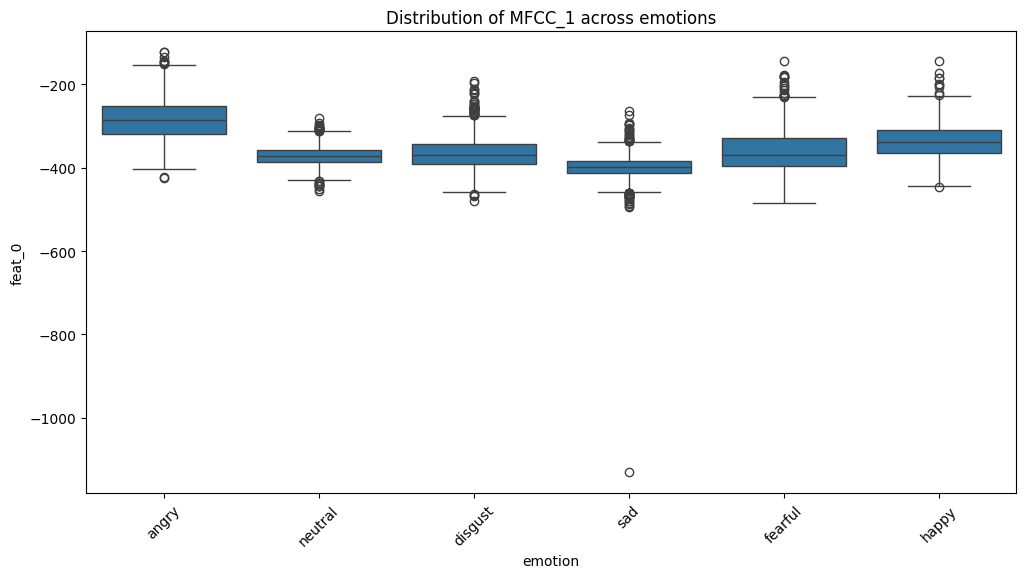

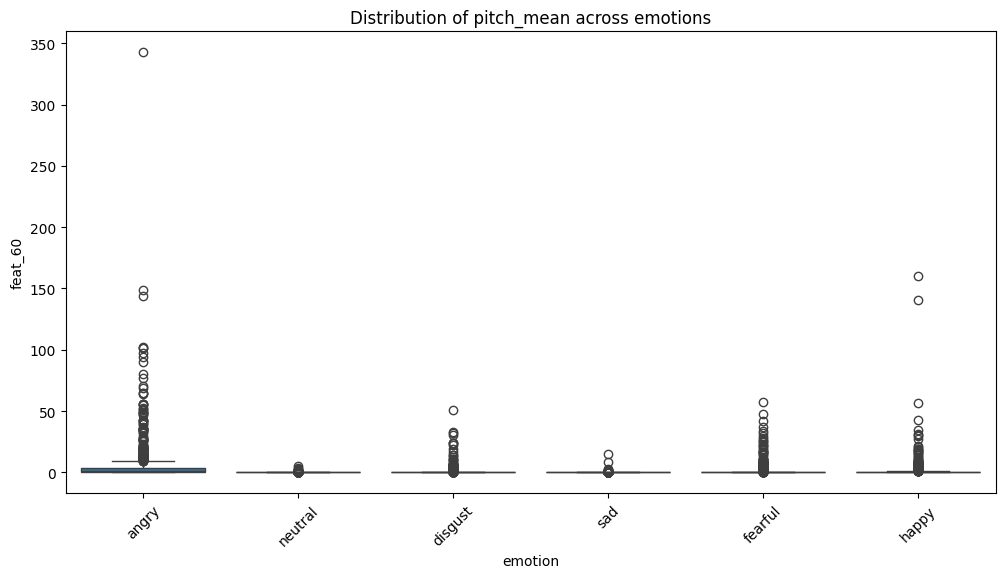

In [2]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Load features
with open('crema_features.pkl', 'rb') as f:
    X, y = pickle.load(f)

# Convert to numpy array if not already
X = np.array(X)
y = np.array(y)

# Create a DataFrame for easier plotting
df = pd.DataFrame(X, columns=[f'feat_{i}' for i in range(X.shape[1])])
df['emotion'] = y

# Plot distribution of MFCC_1 and Pitch by emotion
plt.figure(figsize=(12, 6))
sns.boxplot(x='emotion', y='feat_0', data=df)
plt.title('Distribution of MFCC_1 across emotions')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='emotion', y='feat_60', data=df)  # adjust index if needed
plt.title('Distribution of pitch_mean across emotions')
plt.xticks(rotation=45)
plt.show()

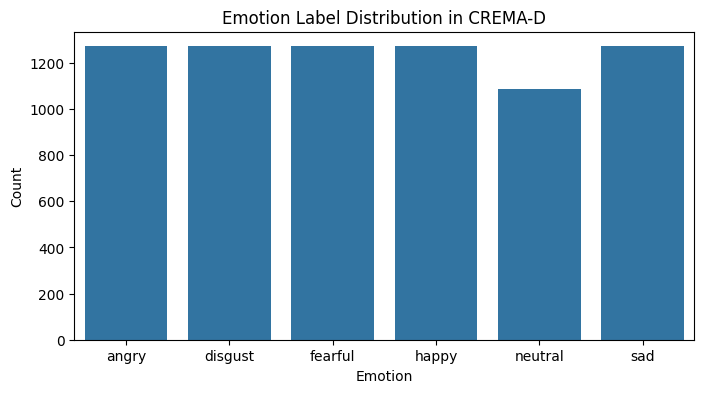

In [3]:
plt.figure(figsize=(8, 4))
sns.countplot(x=y, order=sorted(set(y)))
plt.title("Emotion Label Distribution in CREMA-D")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load extracted features
with open('crema_features.pkl', 'rb') as f:
    X, y = pickle.load(f)

X = np.array(X)
y = np.array(y)

# Step 1: Encode emotion labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Save label mapping for later decoding
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label encoding map:", label_map)

# Step 2: Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"✅ Preprocessed {len(X)} samples: {len(X_train)} train / {len(X_test)} test")

Label encoding map: {np.str_('angry'): np.int64(0), np.str_('disgust'): np.int64(1), np.str_('fearful'): np.int64(2), np.str_('happy'): np.int64(3), np.str_('neutral'): np.int64(4), np.str_('sad'): np.int64(5)}
✅ Preprocessed 7442 samples: 5953 train / 1489 test


✅ Random Forest Accuracy: 0.4916

🔍 Classification Report:
              precision    recall  f1-score   support

       angry       0.65      0.75      0.70       254
     disgust       0.44      0.29      0.35       254
     fearful       0.44      0.20      0.28       254
       happy       0.42      0.49      0.45       255
     neutral       0.42      0.56      0.48       218
         sad       0.52      0.67      0.59       254

    accuracy                           0.49      1489
   macro avg       0.48      0.49      0.47      1489
weighted avg       0.48      0.49      0.47      1489



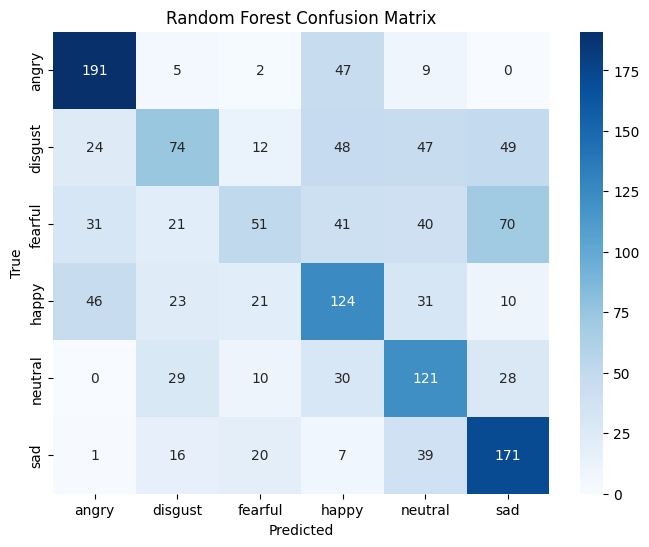

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Train the model
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"✅ Random Forest Accuracy: {acc:.4f}")

# Classification report
print("\n🔍 Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest Confusion Matrix")
plt.show()

# testing a sample audio file

In [19]:

def extract_features_from_file(file_path):
    y, sr = librosa.load(file_path, sr=None)

    # Extract same features
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr), axis=1)
    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    rmse = np.mean(librosa.feature.rms(y=y))
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch = np.mean(pitches[pitches > 0]) if np.any(pitches > 0) else 0

    # Combine into one feature vector
    features = np.hstack([mfcc, chroma, mel, contrast, zcr, rmse, pitch])
    return features

# Example: predict emotion from a new audio file
new_file = "AudioWAV/1091_TAI_SAD_XX.wav"

# Extract features
new_features = extract_features_from_file(new_file).reshape(1, -1)

# Normalize using the same scaler
new_features_scaled = scaler.transform(new_features)

# Predict
pred_label = rf.predict(new_features_scaled)[0]
pred_emotion = label_encoder.inverse_transform([pred_label])[0]

print(f"🎤 Predicted Emotion: {pred_emotion}")

🎤 Predicted Emotion: sad
